---
# **DEEP LEARNING CASE STUDY -** ***Quora Question Pairs similarity using S-BERT***

> **Parameshwari S - CB.SC.I5DAS18026**
--- 


#### **1. Importing all necessary libraries**

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling
import string
import random
import math
import time
from sklearn.utils import resample
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set_style('darkgrid')
import os
from os import listdir
import itertools
import collections
import scipy.stats
import nltk
import torch
import zipfile
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models.doc2vec import Doc2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('punkt')
import gensim
from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
from collections import Counter, defaultdict
from tqdm import tqdm
from sklearn import utils
from sklearn import metrics
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
!pip install transformers
from transformers import AutoTokenizer, AutoModel
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 78 kB 3.3 MB/s 
     |████████████████████████████████| 3.1 MB 18.9 MB/s 
     |████████████████████████████████| 3.3 MB 25.3 MB/s 
     |████████████████████████████████| 1.2 MB 43.9 MB/s 
     |████████████████████████████████| 59 kB 6.0 MB/s 
     |████████████████████████████████| 596 kB 43.5 MB/s 
     |████████████████████████████████| 895 kB 52.2 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=6430659addd677fd798926a605d7cc0d626988ddb7e1d48fb5344939f0184528
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


#### **2. Uploading the data**

In [5]:
train_df = pd.read_csv('/content/train.csv.zip')
train_df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0


In [6]:
train_df.shape

(404290, 6)

#### **3. Data preprocessing**

In [7]:
train_df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [8]:
train_df[train_df.isnull().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [9]:
train_df = train_df.fillna(value="")
train_df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

#### **4. Data exploration**

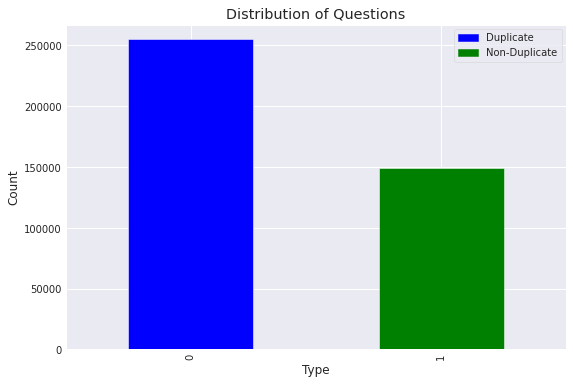

In [ ]:
plt.figure(figsize=(8,6))
train_df.is_duplicate.value_counts().plot(kind='bar', color=['b','g'])

D = mpatches.Patch(color='b', label='Duplicate')
ND = mpatches.Patch(color='g', label='Non-Duplicate')

plt.legend(handles=[D,ND], loc='best')

plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Distribution of Questions')
plt.show()

Mean sentence length for Question1: 59.53670879813995


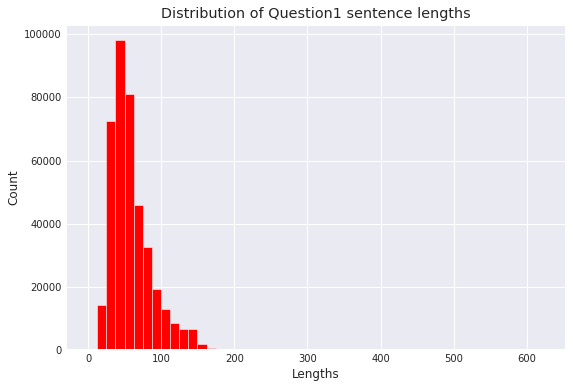

In [ ]:
q1_lengths = [len(q1)for q1 in train_df.question1]
print("Mean sentence length for Question1:", np.mean(q1_lengths))

plt.figure(figsize=(8,6))
plt.hist(q1_lengths,bins=50,color='r')
plt.xlabel('Lengths')
plt.ylabel('Count')
plt.title('Distribution of Question1 sentence lengths')
plt.show()

Mean sentence length for Question2: 60.10836528234683


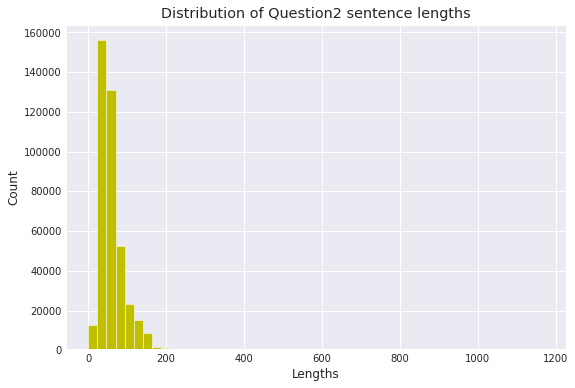

In [ ]:
q2_lengths = [len(q2)for q2 in train_df.question2]
print("Mean sentence length for Question2:", np.mean(q2_lengths))

plt.figure(figsize=(8,6))
plt.hist(q2_lengths,bins=50,color='y')
plt.xlabel('Lengths')
plt.ylabel('Count')
plt.title('Distribution of Question2 sentence lengths')
plt.show()

#### **5. S-BERT Embeddings**


> **a) 100000 rows**



In [ ]:
st_model = SentenceTransformer('bert-base-nli-mean-tokens')

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
sbert_df = train_df[:100000]

In [ ]:
sentences_question1 = list(sent for sent in sbert_df['question1'].values)
sentences_question2 = list(sent for sent in sbert_df['question2'].values)

In [ ]:
def generate_sent_embeddings(data):
    return st_model.encode(data)

In [ ]:
question1_sent_embeddings = generate_sent_embeddings(sentences_question1)
print("shape of question1 sentence embeddings:", question1_sent_embeddings.shape)

shape of question1 sentence embeddings: (100000, 768)


In [ ]:
question2_sent_embeddings = generate_sent_embeddings(sentences_question2)
print("shape of question2 sentence embeddings:", question2_sent_embeddings.shape)

shape of question2 sentence embeddings: (100000, 768)


In [ ]:
sbert_df['question1_sent_embeddings'] = pd.DataFrame({'question1_sent_embeddings' : list(question1_sent_embeddings)})
sbert_df['question2_sent_embeddings'] = pd.DataFrame({'question2_sent_embeddings' : list(question2_sent_embeddings)})

In [ ]:
cos_sim = []
spear_corr = []
for index, row in sbert_df.iterrows():  
  cos_sim.append(cosine_similarity([row['question1_sent_embeddings']],[row['question2_sent_embeddings']]))
  spear_corr.append(scipy.stats.spearmanr(row['question1_sent_embeddings'],row['question2_sent_embeddings'])[0])
sbert_df['cos_sim'] = cos_sim
sbert_df['spear_corr'] = spear_corr

In [16]:
def similarity_to_predictions(cos_sim, threshold):
    if (cos_sim >= threshold):
        return 1
    else:
        return 0

In [ ]:
sbert_df['pred_res(cos_sim)'] = sbert_df['cos_sim'].apply(similarity_to_predictions, threshold=0.87)
sbert_df['pred_res(spear_corr)'] = sbert_df['spear_corr'].apply(similarity_to_predictions, threshold=0.86)

In [ ]:
sbert_df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,question1_sent_embeddings,question2_sent_embeddings,cos_sim,spear_corr,pred_res(cos_sim),pred_res(spear_corr)
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[-0.009722352, -0.32162306, 0.9211391, 0.12629...","[0.15146354, -0.20154329, 0.9581177, 0.0159406...",[[0.84010166]],0.810172,0,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[0.27386734, 0.47279105, -0.6623544, 0.1045286...","[0.19313551, 0.09134984, -1.0451194, 0.5032031...",[[0.7469238]],0.731909,0,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[-0.20832907, -0.15172529, 1.1032256, 0.248804...","[0.27955115, 0.0012331137, -0.03924411, 0.3699...",[[0.89106655]],0.881655,1,1


In [ ]:
print("Accuracy for SBERT embeddings using cosine similarity - ", metrics.accuracy_score(sbert_df['is_duplicate'], sbert_df['pred_res(cos_sim)']))
print("Accuracy for SBERT embeddings using spearman's correlation- ", metrics.accuracy_score(sbert_df['is_duplicate'], sbert_df['pred_res(spear_corr)']))

Accuracy for SBERT embeddings using cosine similarity -  0.72892
Accuracy for SBERT embeddings using spearman's correlation-  0.7286




> **b) 500 rows**



In [ ]:
sbert_df1 = train_df[:500]

In [ ]:
sentences_question1 = list(sent for sent in sbert_df1['question1'].values)
sentences_question2 = list(sent for sent in sbert_df1['question2'].values)

In [ ]:
question1_sent_embeddings = generate_sent_embeddings(sentences_question1)
print("shape of question1 sentence embeddings:", question1_sent_embeddings.shape)

shape of question1 sentence embeddings: (500, 768)


In [ ]:
question2_sent_embeddings = generate_sent_embeddings(sentences_question2)
print("shape of question2 sentence embeddings:", question2_sent_embeddings.shape)

shape of question2 sentence embeddings: (500, 768)


In [ ]:
sbert_df1['question1_sent_embeddings'] = pd.DataFrame({'question1_sent_embeddings' : list(question1_sent_embeddings)})
sbert_df1['question2_sent_embeddings'] = pd.DataFrame({'question2_sent_embeddings' : list(question2_sent_embeddings)})

In [ ]:
cos_sim = []
spear_corr = []
for index, row in sbert_df1.iterrows():  
  cos_sim.append(cosine_similarity([row['question1_sent_embeddings']],[row['question2_sent_embeddings']]))
  spear_corr.append(scipy.stats.spearmanr(row['question1_sent_embeddings'],row['question2_sent_embeddings'])[0])
sbert_df1['cos_sim'] = cos_sim
sbert_df1['spear_corr'] = spear_corr

In [ ]:
sbert_df1['pred_res(cos_sim)'] = sbert_df1['cos_sim'].apply(similarity_to_predictions, threshold=0.86)
sbert_df1['pred_res(spear_corr)'] = sbert_df1['spear_corr'].apply(similarity_to_predictions, threshold=0.86)

In [ ]:
sbert_df1.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,question1_sent_embeddings,question2_sent_embeddings,cos_sim,spear_corr,pred_res(cos_sim),pred_res(spear_corr)
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[-0.009722352, -0.32162306, 0.9211391, 0.12629...","[0.15146354, -0.20154329, 0.9581177, 0.0159406...",[[0.84010166]],0.810172,0,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[0.27386734, 0.47279105, -0.6623544, 0.1045286...","[0.19313551, 0.09134984, -1.0451194, 0.5032031...",[[0.7469238]],0.731909,0,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[-0.20832907, -0.15172529, 1.1032256, 0.248804...","[0.27955115, 0.0012331137, -0.03924411, 0.3699...",[[0.89106655]],0.881655,1,1


In [ ]:
print("Accuracy for SBERT embeddings using cosine similarity - ", metrics.accuracy_score(sbert_df1['is_duplicate'], sbert_df1['pred_res(cos_sim)']))
print("Accuracy for SBERT embeddings using spearman's correlation- ", metrics.accuracy_score(sbert_df1['is_duplicate'], sbert_df1['pred_res(spear_corr)']))

Accuracy for SBERT embeddings using cosine similarity -  0.728
Accuracy for SBERT embeddings using spearman's correlation-  0.726


#### **6. BERT Embeddings**

In [2]:
!pip install BERTSimilarity

  Created wheel for BERTSimilarity: filename=BERTSimilarity-0.1-py3-none-any.whl size=3612 sha256=0dfd843f7ee268ab52d5b733fc6cd868ca7593062ca9a551aae0b44ba5aadc4a
  Stored in directory: /root/.cache/pip/wheels/fa/f7/22/510c1c7131e536fb02b71c619dddcce9636913654ba2f22f22
Successfully built BERTSimilarity


In [3]:
import torch
from transformers import BertTokenizer,BertModel
from scipy.spatial.distance import cosine
class BERTSimilarity():
    def bert_tokenize(self,data):
        self.data=data
        self.output_tokens=''
        self.output_tokens+='[CLS] ' +self.data+' [SEP]'
        return self.output_tokens
    def sentential_embeddings(self,tokenizer,tokenized_text):
        self.tokenizer=tokenizer
        self.tokenized_text=tokenized_text
        self.idx_tokens=self.tokenizer.convert_tokens_to_ids(self.tokenized_text)
        self.segmenter_idx=[1]*len(self.tokenized_text)
        self.tokens_tensor=torch.tensor([self.idx_tokens])
        self.segmenter_tensor=torch.tensor([self.segmenter_idx])
        self.model=BertModel.from_pretrained('bert-base-uncased',output_hidden_states=True)
        self.model.eval()
        with torch.no_grad():
            self.outputs=self.model(self.tokens_tensor,self.segmenter_tensor)
            self.hidden_state=self.outputs[2]
        self.embedding_token=torch.stack(self.hidden_state,dim=0)
        self.embedding_token=torch.squeeze(self.embedding_token,dim=1)
        self.embedding_token=self.embedding_token.permute(1,0,2)
        self.vs_sum_cat=[]
        for i in self.embedding_token:
            vs_li=torch.sum(i[-4:],dim=0)
            self.vs_sum_cat.append(vs_li)
        self.token_vecs=self.hidden_state[-2][0]
        self.sentence_embeddings=torch.mean(self.token_vecs,dim=0)
        return self.sentence_embeddings,self.vs_sum_cat
    def calculate_distance(self,sentence_1,sentence_2):
        self.sentence_1=sentence_1
        self.sentence_2=sentence_2
        self.tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')
        self.preprocess_1=self.bert_tokenize(self.sentence_1)
        self.preprocess_2=self.bert_tokenize(self.sentence_2)
        self.tokenized_text_1=self.tokenizer.tokenize(self.preprocess_1)
        self.tokenized_text_2=self.tokenizer.tokenize(self.preprocess_2)
        self.sentence_1,self.vs_sum_cat1=self.sentential_embeddings(self.tokenizer,self.tokenized_text_1)
        self.sentence_2,self.vs_sum_cat2=self.sentential_embeddings(self.tokenizer,self.tokenized_text_2)
        self.distance=1-cosine(self.sentence_1,self.sentence_2)
        return self.distance
    def corr(self,sentence_1,sentence_2):
        self.sentence_1=sentence_1
        self.sentence_2=sentence_2
        self.tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')
        self.preprocess_1=self.bert_tokenize(self.sentence_1)
        self.preprocess_2=self.bert_tokenize(self.sentence_2)
        self.tokenized_text_1=self.tokenizer.tokenize(self.preprocess_1)
        self.tokenized_text_2=self.tokenizer.tokenize(self.preprocess_2)
        self.sentence_1,self.vs_sum_cat1=self.sentential_embeddings(self.tokenizer,self.tokenized_text_1)
        self.sentence_2,self.vs_sum_cat2=self.sentential_embeddings(self.tokenizer,self.tokenized_text_2)
        self.spcorr=scipy.stats.spearmanr(self.sentence_1,self.sentence_2)[0]
        return self.spcorr

In [4]:
bertsimilarity=BERTSimilarity()

In [12]:
from transformers import logging
logging.set_verbosity_error()

In [13]:
bert_df = train_df[:500]

In [14]:
distances=[]
spear_corr = []
for i in range(len(bert_df)):
  q1=bert_df['question1'][i]
  q2=bert_df['question2'][i]
  distances.append(bertsimilarity.calculate_distance(q1,q2)) 
  spear_corr.append(bertsimilarity.corr(q1,q2))

bert_df['cos_sim']=distances
bert_df['spear_corr']=spear_corr

In [29]:
bert_df['pred_res(cos_sim)'] = bert_df['cos_sim'].apply(similarity_to_predictions, threshold=0.89)
bert_df['pred_res(spear_corr)'] = bert_df['spear_corr'].apply(similarity_to_predictions, threshold=0.87)

In [30]:
bert_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cos_sim,spear_corr,pred_res(cos_sim),pred_res(spear_corr)
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.970151,0.937000,1,1
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0.905713,0.770143,1,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0.923254,0.811675,1,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0.610703,0.356798,0,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0.761775,0.490774,0,0


In [31]:
print("Accuary for BERT embeddings using cosine similarity- ", metrics.accuracy_score(bert_df['is_duplicate'], bert_df['pred_res(cos_sim)']))
print("Accuary for BERT embeddings using spearman's correlation- ", metrics.accuracy_score(bert_df['is_duplicate'], bert_df['pred_res(spear_corr)']))

Accuary for BERT embeddings using cosine similarity-  0.692
Accuary for BERT embeddings using spearman's correlation-  0.662


#### **7. Universal Sentene Encoder embeddings**

In [ ]:
!pip3 install --upgrade tensorflow-gpu
!pip3 install tensorflow-hub

     |████████████████████████████████| 489.6 MB 24 kB/s 


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
model = hub.load(module_url)
print ("module %s loaded" % module_url)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.


module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [ ]:
use_df = train_df[:500]

In [ ]:
sentences_question1 = list(sent for sent in use_df['question1'].values)
sentences_question2 = list(sent for sent in use_df['question2'].values)

In [ ]:
sentence1_embeddings = model(sentences_question1)
print("shape of question1 sentence embeddings:", sentence1_embeddings.shape)
sentence2_embeddings = model(sentences_question2)
print("shape of question2 sentence embeddings:", sentence2_embeddings.shape)

shape of question1 sentence embeddings: (500, 512)
shape of question2 sentence embeddings: (500, 512)


In [ ]:
use_df['question1_sent_embeddings'] = pd.DataFrame({'question1_sent_embeddings' : list(sentence1_embeddings)})
use_df['question2_sent_embeddings'] = pd.DataFrame({'question2_sent_embeddings' : list(sentence2_embeddings)})

In [ ]:
cos_sim = []
spear_corr = []
for index, row in use_df.iterrows():  
  cos_sim.append(cosine_similarity([row['question1_sent_embeddings']],[row['question2_sent_embeddings']]))
  spear_corr.append(scipy.stats.spearmanr(row['question1_sent_embeddings'],row['question2_sent_embeddings'])[0])
use_df['cos_sim'] = cos_sim
use_df['spear_corr'] = spear_corr

In [ ]:
use_df['pred_res(cos_sim)'] = use_df['cos_sim'].apply(similarity_to_predictions, threshold=0.86)
use_df['pred_res(spear_corr)'] = use_df['spear_corr'].apply(similarity_to_predictions, threshold=0.88)

In [ ]:
use_df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,question1_sent_embeddings,question2_sent_embeddings,cos_sim,spear_corr,pred_res(cos_sim),pred_res(spear_corr)
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"(tf.Tensor(0.0021821507, shape=(), dtype=float...","(tf.Tensor(0.018747559, shape=(), dtype=float3...",[[0.9364382]],0.934645,1,1
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"(tf.Tensor(-0.0081168795, shape=(), dtype=floa...","(tf.Tensor(-0.026330141, shape=(), dtype=float...",[[0.68438935]],0.675223,0,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"(tf.Tensor(-0.025076203, shape=(), dtype=float...","(tf.Tensor(-0.019373633, shape=(), dtype=float...",[[0.60938096]],0.589570,0,0


In [ ]:
print("Accuracy for USE embeddings using cosine similarity - ", metrics.accuracy_score(use_df['is_duplicate'], use_df['pred_res(cos_sim)']))
print("Accuracy for USE embeddings using spearman's correlation- ", metrics.accuracy_score(use_df['is_duplicate'], use_df['pred_res(spear_corr)']))

Accuracy for USE embeddings using cosine similarity -  0.688
Accuracy for USE embeddings using spearman's correlation-  0.686


#### **8. RoBERTa embeddings**

In [ ]:
rb_model = SentenceTransformer('roberta-base-nli-stsb-mean-tokens')

Downloading:   0%|          | 0.00/748 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.00k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/688 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/334 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
roberta_df = train_df[:500]

In [ ]:
sentences_question1 = list(sent for sent in roberta_df['question1'].values)
sentences_question2 = list(sent for sent in roberta_df['question2'].values)

In [ ]:
def generate_sent_embeddings(data):
    return rb_model.encode(data)

In [ ]:
sentence1_embeddings = generate_sent_embeddings(sentences_question1)
print("shape of question1 sentence embeddings:", sentence1_embeddings.shape)
sentence2_embeddings = generate_sent_embeddings(sentences_question2)
print("shape of question2 sentence embeddings:", sentence2_embeddings.shape)

shape of question1 sentence embeddings: (500, 768)
shape of question2 sentence embeddings: (500, 768)


In [ ]:
roberta_df['question1_sent_embeddings'] = pd.DataFrame({'question1_sent_embeddings' : list(question1_sent_embeddings)})
roberta_df['question2_sent_embeddings'] = pd.DataFrame({'question2_sent_embeddings' : list(question2_sent_embeddings)})

In [ ]:
cos_sim = []
spear_corr = []
for index, row in roberta_df.iterrows():  
  cos_sim.append(cosine_similarity([row['question1_sent_embeddings']],[row['question2_sent_embeddings']]))
  spear_corr.append(scipy.stats.spearmanr(row['question1_sent_embeddings'],row['question2_sent_embeddings'])[0])
roberta_df['cos_sim'] = cos_sim
roberta_df['spear_corr'] = spear_corr

In [ ]:
roberta_df['pred_res(cos_sim)'] = roberta_df['cos_sim'].apply(similarity_to_predictions, threshold=0.86)
roberta_df['pred_res(spear_corr)'] = roberta_df['spear_corr'].apply(similarity_to_predictions, threshold=0.86)

In [ ]:
roberta_df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,question1_sent_embeddings,question2_sent_embeddings,cos_sim,spear_corr,pred_res(cos_sim),pred_res(spear_corr)
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[-0.009722352, -0.32162306, 0.9211391, 0.12629...","[0.15146354, -0.20154329, 0.9581177, 0.0159406...",[[0.84010166]],0.810172,0,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[0.27386734, 0.47279105, -0.6623544, 0.1045286...","[0.19313551, 0.09134984, -1.0451194, 0.5032031...",[[0.7469238]],0.731909,0,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[-0.20832907, -0.15172529, 1.1032256, 0.248804...","[0.27955115, 0.0012331137, -0.03924411, 0.3699...",[[0.89106655]],0.881655,1,1


In [ ]:
print("Accuary for RoBERTa embeddings using cosine similarity- ", metrics.accuracy_score(roberta_df['is_duplicate'], roberta_df['pred_res(cos_sim)']))
print("Accuary for RoBERTa embeddings using spearman's correlation- ", metrics.accuracy_score(roberta_df['is_duplicate'], roberta_df['pred_res(spear_corr)']))

Accuary for RoBERTa embeddings using cosine similarity-  0.728
Accuary for RoBERTa embeddings using spearman's correlation-  0.726


#### **9. InferSent embeddings**

In [ ]:
!wget -c http://nlp.stanford.edu/data/glove.840B.300d.zip
!wget -c https://dl.fbaipublicfiles.com/infersent/infersent1.pkl
!wget -c https://raw.githubusercontent.com/facebookresearch/InferSent/master/models.py

--2021-11-19 05:28:05--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2021-11-19 05:28:06--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2021-11-19 05:28:06--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip

In [ ]:
with zipfile.ZipFile("/content/glove.840B.300d.zip", "r") as zipread:
  zipread.extractall("/content/")
  zipread.close

In [ ]:
from models import InferSent

MODEL_PATH = '/content/infersent1.pkl'
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': 2}
infersent = InferSent(params_model)
infersent.load_state_dict(torch.load(MODEL_PATH))

infersent.set_w2v_path("/content/glove.840B.300d.txt")

In [ ]:
infersent_df = train_df[:500]

In [ ]:
import itertools
from itertools import chain

infersent.build_vocab(list(chain(infersent_df.question1, infersent_df.question2)), tokenize=True)

Found 2665(/2739) words with w2v vectors
Vocab size : 2665


In [ ]:
embeddings1 = infersent.encode(infersent_df.question1, tokenize=True)
embeddings2 = infersent.encode(infersent_df.question2, tokenize=True)

In [ ]:
cos_sim = []
spear_corr = []
for (e1, e2) in zip(embeddings1, embeddings2):
  cos_sim.append(cosine_similarity(e1.reshape(1,-1), e2.reshape(1,-1))[0][0])
  spear_corr.append(scipy.stats.spearmanr(e1, e2)[0])
infersent_df["cos_sim"] = cos_sim
infersent_df["spear_corr"] = spear_corr

In [ ]:
infersent_df['pred_res(cos_sim)'] = infersent_df['cos_sim'].apply(similarity_to_predictions, threshold=0.85)
infersent_df['pred_res(spear_corr)'] = infersent_df['spear_corr'].apply(similarity_to_predictions, threshold=0.85)

In [ ]:
infersent_df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,cos_sim,spear_corr,pred_res(cos_sim),pred_res(spear_corr)
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.953249,0.921047,1,1
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0.832436,0.702478,0,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0.868755,0.768777,1,0


In [ ]:
print("Accuary for InferSent embeddings using cosine similarity- ", metrics.accuracy_score(infersent_df['is_duplicate'], infersent_df['pred_res(cos_sim)']))
print("Accuary for InferSent embeddings using spearman's correlation- ", metrics.accuracy_score(infersent_df['is_duplicate'], infersent_df['pred_res(spear_corr)']))

Accuary for InferSent embeddings using cosine similarity-  0.682
Accuary for InferSent embeddings using spearman's correlation-  0.654


#### **10. Semantic Search using SBERT**

In [ ]:
semser_df = train_df[:100]
semser_df.shape

(100, 6)

In [ ]:
q1 = semser_df.question1.tolist()
q2 = semser_df.question2.tolist()

In [ ]:
sentences = q1 + q2
sentence_embeddings = st_model.encode(sentences)

In [ ]:
print('Sample BERT embedding vector - length', len(sentence_embeddings[0]))

Sample BERT embedding vector - length 768


In [ ]:
query = semser_df['question1'][28] 

queries = [query]
query_embeddings = st_model.encode(queries)
n = 4

print("Semantic Search Results")

for query, query_embedding in zip(queries, query_embeddings):
    distances = scipy.spatial.distance.cdist([query_embedding], sentence_embeddings, "cosine")[0]
    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])
    print("Query:", query)
    print("\nTop 3 most similar sentences - ")
    for idx, distance in results[0:n]:
        print(sentences[idx].strip(), "(Cosine Score: %.4f)" % (1-distance))

Semantic Search Results
Query: What is best way to make money online?

Top 3 most similar sentences - 
What is best way to make money online? (Cosine Score: 1.0000)
What is best way to ask for money online? (Cosine Score: 0.9583)
How can I make money through the Internet? (Cosine Score: 0.7752)
What are some different ways to make money online, excluding selling things? (Cosine Score: 0.7561)
